### Accredian Data Science Researcher Internship Task 
##### By Jomy Mary Mathew
##### Detailed Report at the end of the notebook

#### Business Context: Develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan.

Loading the dataset (Fraud.csv) using pandas library

In [2]:
import pandas as pd
data = pd.read_csv('Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Checking the shape of the dataset, i.e number of rows and columns

In [3]:
data.shape

(6362620, 11)

Dataset contains 6 Million rows and 11 columns (both categorical and numerical)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


All the columns have correct datatype - so not required to change the datatype format

In [5]:
data.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


Dataset contains no missing (null) values

#### Descriptive statistics 

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # Turn off scientific notation
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


Interpretation:
Severe class imbalance → Only ~0.13% of data is labeled as fraud.

Large range in balances and amount → Data is highly skewed; likely requires log transformation or outlier handling.

Many zero balances in origin/destination → Suggests that fraudsters might use empty or newly created accounts.

isFlaggedFraud is almost always 0, meaning rule-based systems are likely ineffective alone.

### Feature Engineering and Exploratory Data Analysis (EDA)

##### step column- maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

step = unit of time, where 1 step = 1 hour

There are 744 steps, meaning the dataset spans 30 days of transactions

In [7]:
data['step']

,step
0,1
1,1
2,1
3,1
4,1
...,...
6362615,743
6362616,743
6362617,743
6362618,743


Day and Hour can be extracted through the 'Step' column which could provide additional information to the model

In [8]:
data['day'] = (data['step'] // 24) + 1       # Day 1 to 31
data['hour'] = data['step'] % 24             # Hour of the day (0–23)

In [9]:
data['day']

,day
0,1
1,1
2,1
3,1
4,1
...,...
6362615,31
6362616,31
6362617,31
6362618,31


New 'day' columns contains values from 1 to 31 (indicating the number of days)

In [10]:
data['hour']

,hour
0,1
1,1
2,1
3,1
4,1
...,...
6362615,23
6362616,23
6362617,23
6362618,23


New column 'hour' contains hours from 1 to 23 (indicating the number of hours in a day)

### Plots - Day, Hour vs isFraud

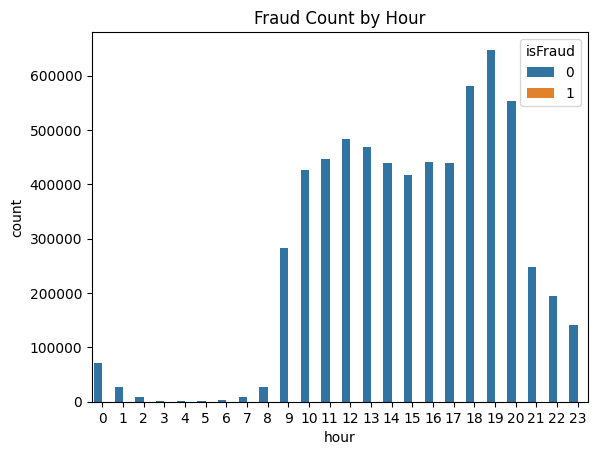

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='hour', hue='isFraud', data=data)
plt.title('Fraud Count by Hour')
plt.show()

As the dataset is highly imbalanced the above graph is biased towards '0' (Not Fraud) and shows that most non - fraudalent activities are after 8 Hour and 20th Hour

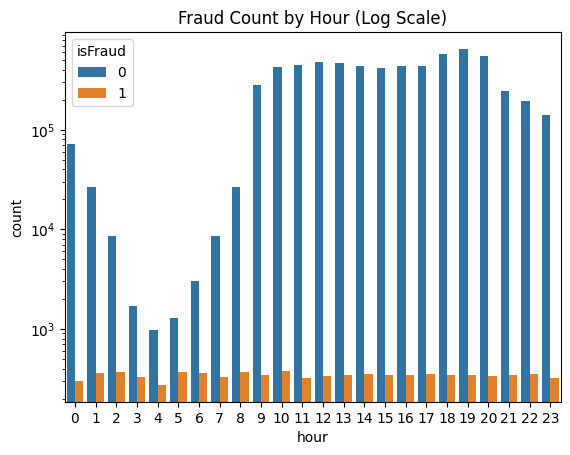

In [12]:
sns.countplot(x='hour', hue='isFraud', data=data)
plt.yscale('log')
plt.title('Fraud Count by Hour (Log Scale)')
plt.show()

This chart provides valuable insights into the absolute numbers of both legitimate and fraudulent transactions over the 24-hour cycle. It clearly highlights the class imbalance inherent in fraud data.

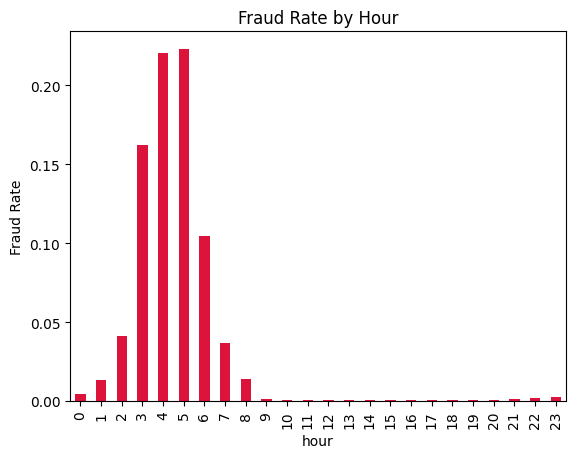

In [13]:
fraud_by_hour = data.groupby('hour')['isFraud'].mean()
fraud_by_hour.plot(kind='bar', color='crimson')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Hour')
plt.show()

 The chart suggests that fraudulent activities are predominantly concentrated in the very early morning hours, particularly between 4 AM and 5 AM, and are significantly lower during other parts of the day.

Insight:
Analysis of the transaction step column (which maps to hours of the month) revealed that fraudulent transactions are disproportionately high between 4 AM and 5 AM.

This time window might represent a low-activity period when users and security teams are less active, giving fraudsters an advantage.

Actionable Suggestion: Implement tighter security checks (e.g., two-factor authentication or velocity checks) during this time.

Raise fraud scores during these hours to trigger manual reviews more frequently.

Type Column: Type of Transaction made - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

In [14]:
data['type'].value_counts()

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


Usually most fraudalent transactions are of type CASH_OT AND TRANSFER - WILL LOOK ON THOSE 2 TYPES PARTICULARLY

#### PLOTS - TYPE VS TRANSACTION

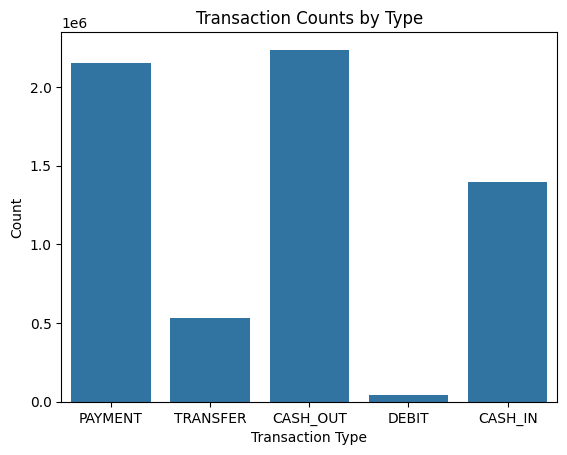

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=data, x='type')
plt.title('Transaction Counts by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

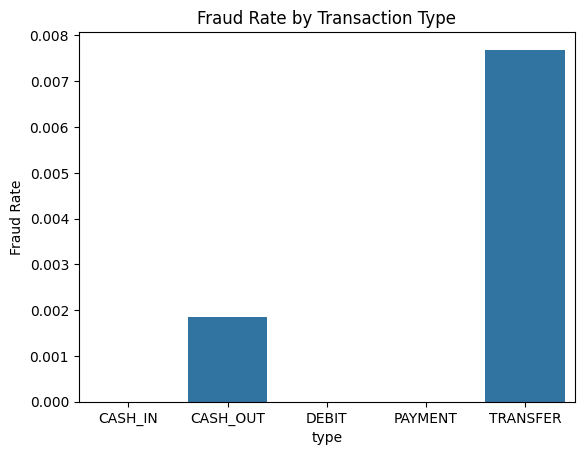

In [16]:
fraud_rate = data.groupby('type')['isFraud'].mean().reset_index()
sns.barplot(data=fraud_rate, x='type', y='isFraud')
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Fraud Rate')
plt.show()

The chart clearly indicates that "TRANSFER" transactions have a much higher fraud rate than "CASH_OUT" transactions.

"TRANSFER" transactions should be subject to more stringent scrutiny or higher-priority fraud detection algorithms.

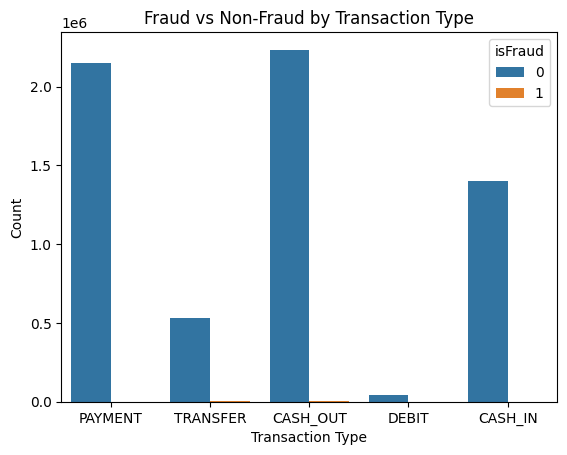

In [17]:
sns.countplot(data=data, x='type', hue='isFraud')
plt.title('Fraud vs Non-Fraud by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.legend(title='isFraud')
plt.show()

Even though CASH_OUT transactions are much more frequent in general (higher blue bar), their individual risk of being fraudulent (fraud rate) is lower.

Conversely, TRANSFER transactions are less frequent overall, but when they do occur, they have a higher probability of being fraudulent (higher fraud rate).

In [18]:
data.groupby('type')['isFraud'].mean().sort_values(ascending=False)

,isFraud
type,
TRANSFER,0.01
CASH_OUT,0.00
CASH_IN,0.00
DEBIT,0.00
PAYMENT,0.00


In [19]:
data.groupby('type')['isFraud'].sum()

,isFraud
type,
CASH_IN,0
CASH_OUT,4116
DEBIT,0
PAYMENT,0
TRANSFER,4097


In [20]:
data = data[data['type'].isin(['CASH_OUT', 'TRANSFER'])]

Transaction types with zero fraud occurrences were removed to focus model training on patterns that are relevant for detecting fraudulent behavior, reducing dimensionality and noise.

In [21]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,hour
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,1,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,1,1
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,0,1,1
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.00,0,0,1,1
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.00,2719172.89,0,0,1,1


In [22]:
data.shape

(2770409, 13)

Some rows has been removed, as the dataset contains now contains type - CASH_OUT & TRANSFER

In [23]:
data['type'] = data['type'].map({'TRANSFER': 0, 'CASH_OUT': 1})

0 → 'TRANSFER'

1 → 'CASH_OUT'

This helps ML models work with it as a numerical feature instead of a category.



In [24]:
data['type'].value_counts()

,count
type,
1,2237500
0,532909


Most transactions are 1 (TRANSFER) compared to 0 (CASH_OUT)

#### Amount Column: amount of the transaction in local currency

##### Distribution of Transaction amounts

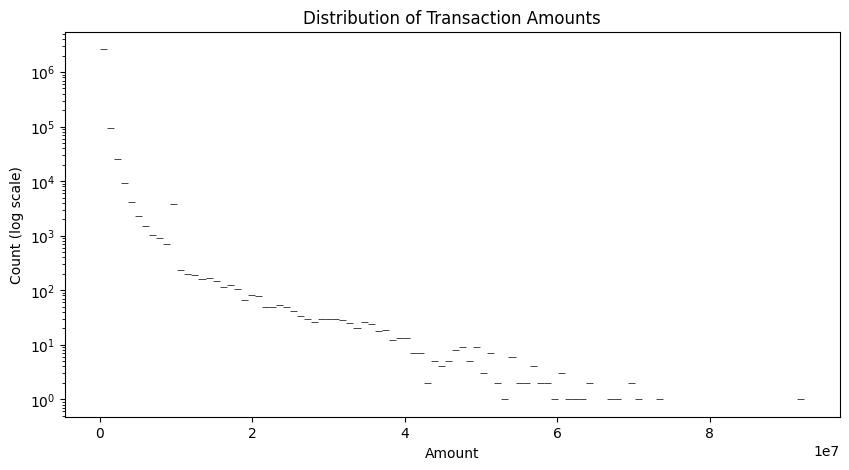

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
sns.histplot(data['amount'], bins=100, log_scale=(False, True))
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Count (log scale)')
plt.show()

The chart effectively illustrates that financial transactions typically follow a highly skewed distribution, with a massive volume of small-value transactions and a decreasing number of transactions as the amount increases, extending to a few very large-value transactions.

This skewness indicates that it would require log transformation

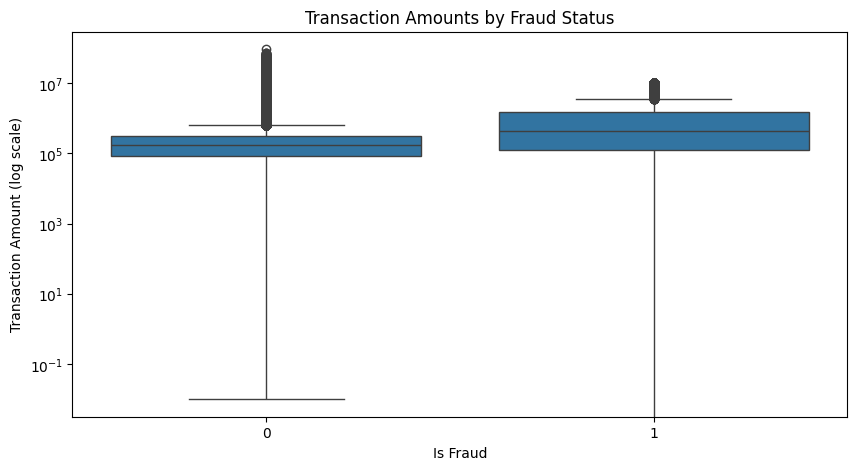

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='isFraud', y='amount', data=data)
plt.title('Transaction Amounts by Fraud Status')
plt.yscale('log')  # Helps with outliers
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount (log scale)')
plt.show()

The most striking difference is that fraudulent transactions tend to have significantly higher median amounts compared to non-fraudulent transactions. This suggests that fraudsters are often attempting to transfer or cash out larger sums of money.

This pattern is extremely valuable for fraud detection. Transaction amount can be a strong indicator of fraud. Transactions with unusually high values (especially when compared to the typical legitimate transaction amounts) should be flagged for closer inspection.

/tmp/ipython-input-27-2677078466.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[data['isFraud']==0]['amount'], label='Non-Fraud', shade=True)
/tmp/ipython-input-27-2677078466.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[data['isFraud']==1]['amount'], label='Fraud', shade=True, color='red')


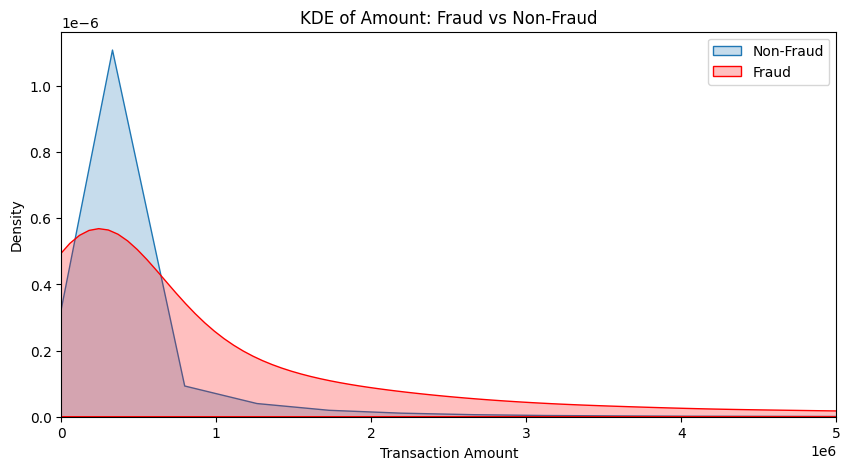

In [27]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=data[data['isFraud']==0]['amount'], label='Non-Fraud', shade=True)
sns.kdeplot(data=data[data['isFraud']==1]['amount'], label='Fraud', shade=True, color='red')
plt.title('KDE of Amount: Fraud vs Non-Fraud')
plt.xlabel('Transaction Amount')
plt.legend()
plt.xlim(0, 5000000)
plt.show()

The peak for fraudulent transactions is shifted to the right, indicating that while there are still some low-value fraudulent transactions, the density is higher for larger amounts compared to non-fraudulent transactions in that range.

The red curve extends further out to higher amounts with more significant density than the blue curve, particularly beyond an amount of approximately 1×10
5
  (100,000). This suggests that fraudulent transactions tend to involve higher amounts than typical legitimate transactions.

Conclusion: This chart strongly suggests that transaction amount is a very distinguishing feature for fraud.

New column: 'is_high_amount' - used for flagging transaction amount > 95th percentile

In [28]:
threshold = data['amount'].quantile(0.95)
data['is_high_amount'] = (data['amount'] > threshold).astype(int)

In [29]:
data['is_high_amount'].value_counts()

,count
is_high_amount,
0,2631888
1,138521


About 5% of the transactions are "high amount" (as expected if you used the 95th percentile).

This aligns with the idea that most fraud occurs in high-value transactions, so this binary flag can help your model detect patterns more easily.

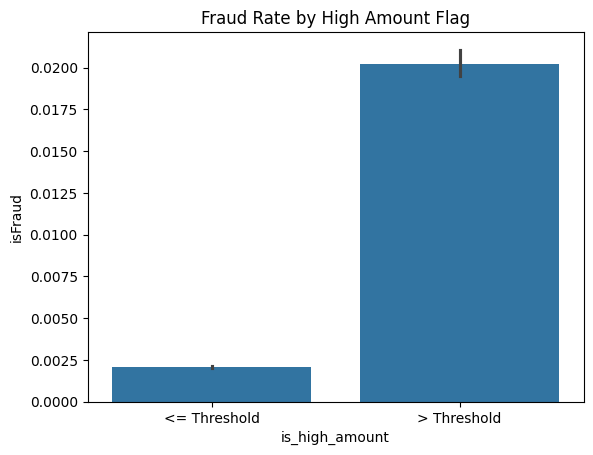

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='is_high_amount', y='isFraud', data=data)
plt.title('Fraud Rate by High Amount Flag')
plt.xticks([0,1], ['<= Threshold', '> Threshold'])
plt.show()

Transactions with amounts above a certain threshold are significantly more prone to fraud than transactions below that threshold. This reinforces the idea from previous analyses (like the KDE plot) that transaction amount is a strong predictor of fraud, with higher amounts being riskier.

##### Log - Transformation of Amount column - to reduce the skewness

In [31]:
data['log_amount'] = np.log1p(data['amount'])  # log(1 + x)

In [32]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,hour,is_high_amount,log_amount
2,1,0,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,1,1,0,5.20
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,1,1,0,5.20
15,1,1,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,0,1,1,0,12.34
19,1,0,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.00,0,0,1,1,0,12.28
24,1,0,311685.89,C1984094095,10835.00,0.00,C932583850,6267.00,2719172.89,0,0,1,1,0,12.65


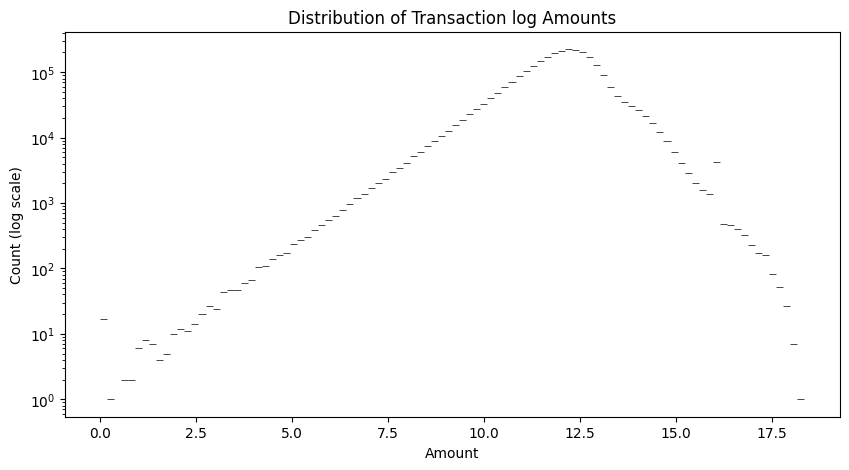

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
sns.histplot(data['log_amount'], bins=100, log_scale=(False, True))
plt.title('Distribution of Transaction log Amounts')
plt.xlabel('Amount')
plt.ylabel('Count (log scale)')
plt.show()

After log transformation the distribution now looks normal

##### New column: 'orig_txn_count' - helps to know the number of transaction per customer

In [34]:
txn_counts = data['nameOrig'].value_counts().to_dict()
data['orig_txn_count'] = data['nameOrig'].map(txn_counts)

In [35]:
data['orig_txn_count'].value_counts()

,count
orig_txn_count,
1,2766854
2,3546
3,9


Most customers have made a single transactions with few 2, or 3

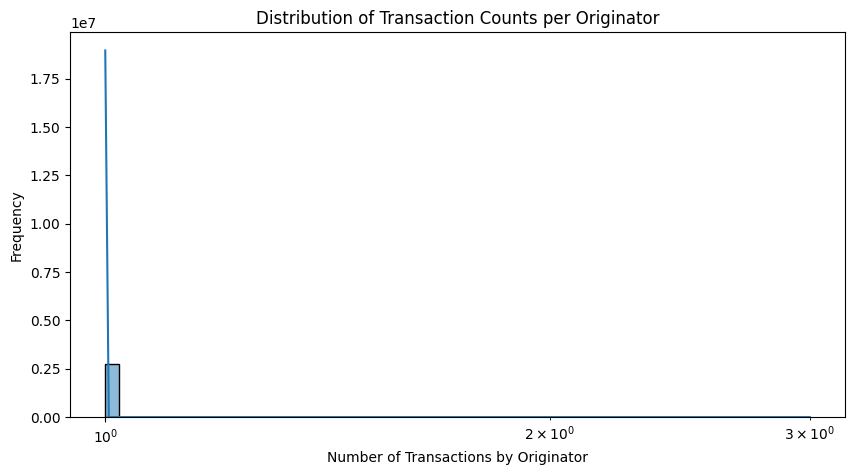

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data['orig_txn_count'], bins=50, log_scale=(True, False), kde=True)
plt.title('Distribution of Transaction Counts per Originator')
plt.xlabel('Number of Transactions by Originator')
plt.ylabel('Frequency')
plt.show()

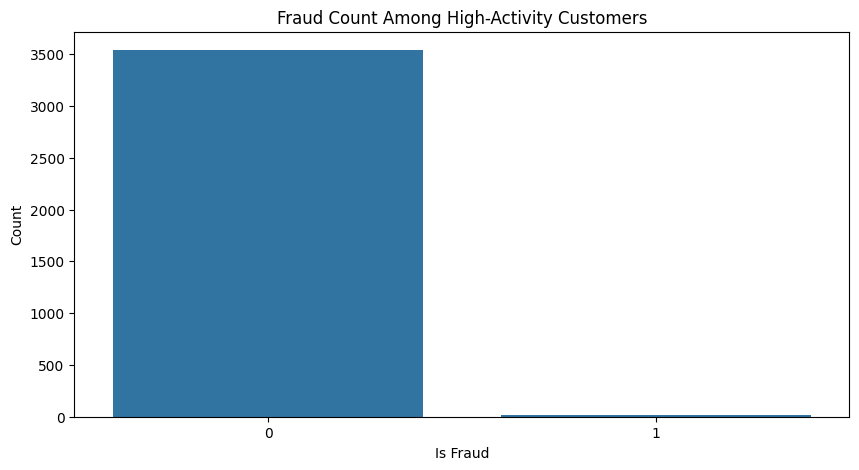

In [37]:
high_txn_threshold = data['orig_txn_count'].quantile(0.99)

plt.figure(figsize=(10, 5))
sns.countplot(x='isFraud', data=data[data['orig_txn_count'] > high_txn_threshold])
plt.title('Fraud Count Among High-Activity Customers')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

This chart strongly suggests that "High-Activity Customers" are very unlikely to be involved in fraud. This is a significant finding: it implies that customers who engage in frequent, legitimate transactions are a low-risk group. This could be used to whitelist certain accounts or reduce scrutiny on their transactions, allowing fraud detection systems to focus resources elsewhere.

#### New column: withdraw_ratio - (The percentage of the available balance being withdrawn.)



≈ 1 → almost entire balance being withdrawn (suspicious).

≈ 0 → small or negligible withdrawal relative to balance (normal).

value > 1 → trying to withdraw more than available balance (invalid).

In [38]:
data['withdraw_ratio'] = data['amount'] / (data['oldbalanceOrg'] + 1)

#### New column: leftover_balance	- (The fraction of balance left after the transaction.)

≈ 0 → account likely emptied (suspicious).

≈ 1 → little to no withdrawal (normal).

< 0 or unexpected value → possibly erroneous or fraudulent.

In [39]:
data['leftover_balance'] = data['newbalanceOrig'] / (data['oldbalanceOrg'] + 1)

#### New Column: is_account_emptied - (Whether the origin account was completely drained.)

1 → yes, account was emptied (could be fraud).

0 → no, balance remains.

In [40]:
data['is_account_emptied'] = (data['newbalanceOrig'] == 0).astype(int)

#### New Column: insufficient_funds - (Whether the transaction attempted to withdraw more than the available balance.)

1 → insufficient funds (suspicious or invalid).

0 → funds were sufficient.

In [41]:
data['insufficient_funds'] = (data['amount'] > data['oldbalanceOrg']).astype(int)

#### New Column: balance_anomaly - (A suspicious case: trying to send money when the balance is zero.)

1 → anomaly: non-zero transaction with zero balance (possibly synthetic or fake).

0 → normal.

In [42]:
data['balance_anomaly'] = ((data['amount'] > 0) & (data['oldbalanceOrg'] == 0)).astype(int)

In [43]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,day,hour,is_high_amount,log_amount,orig_txn_count,withdraw_ratio,leftover_balance,is_account_emptied,insufficient_funds,balance_anomaly
2,1,0,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,...,1,1,0,5.20,1,0.99,0.00,1,0,0
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,...,1,1,0,5.20,1,0.99,0.00,1,0,0
15,1,1,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,...,1,1,0,12.34,1,14.95,0.00,1,1,0
19,1,0,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.00,0,...,1,1,0,12.28,1,304.97,0.00,1,1,0
24,1,0,311685.89,C1984094095,10835.00,0.00,C932583850,6267.00,2719172.89,0,...,1,1,0,12.65,1,28.76,0.00,1,1,0


Checking the co-relation with the target 'isFraud' column

In [44]:
data[['withdraw_ratio', 'leftover_balance', 'is_account_emptied', 'insufficient_funds', 'balance_anomaly', 'isFraud']].corr()

,withdraw_ratio,leftover_balance,is_account_emptied,insufficient_funds,balance_anomaly,isFraud
withdraw_ratio,1.00,-0.06,0.07,0.07,0.22,-0.01
leftover_balance,-0.06,1.00,-0.88,-0.86,-0.27,-0.01
is_account_emptied,0.07,-0.88,1.00,0.98,0.31,0.01
insufficient_funds,0.07,-0.86,0.98,1.00,0.32,-0.16
balance_anomaly,0.22,-0.27,0.31,0.32,1.00,-0.05
isFraud,-0.01,-0.01,0.01,-0.16,-0.05,1.00


insufficient_funds	-0.16	Strongest signal here. Fraudulent transactions often involve insufficient funds.

#### New Column: is_merchant - (Checks if the namedest starts with 'M' and assigns 1 if yes and 0 if no)

In [45]:
data['is_merchant'] = data['nameDest'].str.startswith('M').astype(int)

1 → Destination is a merchant

0 → Destination is a regular customer

Fraud rarely targets merchant accounts, and balance info for them is often 0.

#### New Column: dest_txn_counts - This shows how active a destination is.

In [46]:
dest_txn_counts = data['nameDest'].value_counts().to_dict()
data['dest_txn_count'] = data['nameDest'].map(dest_txn_counts)

Fraudsters often use destination accounts only once or a few times, so low counts can be suspicious.

#### New Column: dest_balance_missing - (Checks whether the destination balance is missing)

In [47]:
data['dest_balance_missing'] = ((data['oldbalanceDest'] == 0) & (data['newbalanceDest'] == 0)).astype(int)

Merchants often have:

oldbalanceDest == 0

newbalanceDest == 0

#### New Column: is_dest_known_fraud - (Has the destination been in a fraud transaction)

In [48]:
fraud_dest_set = set(data[data['isFraud'] == 1]['nameDest'])
data['is_dest_known_fraud'] = data['nameDest'].apply(lambda x: int(x in fraud_dest_set))

In [49]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,orig_txn_count,withdraw_ratio,leftover_balance,is_account_emptied,insufficient_funds,balance_anomaly,is_merchant,dest_txn_count,dest_balance_missing,is_dest_known_fraud
2,1,0,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,...,1,0.99,0.00,1,0,0,0,27,1,1
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,...,1,0.99,0.00,1,0,0,0,31,0,1
15,1,1,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,...,1,14.95,0.00,1,1,0,0,28,0,0
19,1,0,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.00,0,...,1,304.97,0.00,1,1,0,0,31,0,0
24,1,0,311685.89,C1984094095,10835.00,0.00,C932583850,6267.00,2719172.89,0,...,1,28.76,0.00,1,1,0,0,51,0,1


#### New Columns: dest_balance_diff, is_dest_empty_before, is_dest_balance_unchanged

In [50]:
data['dest_balance_diff'] = data['newbalanceDest'] - data['oldbalanceDest']
data['is_dest_empty_before'] = (data['oldbalanceDest'] == 0).astype(int)
data['is_dest_balance_unchanged'] = (data['dest_balance_diff'] == 0).astype(int)

#### Checking the new columns coorelation with the target column 'isFraud'

In [51]:
features_to_check = [
    'dest_balance_diff',
    'is_dest_empty_before',
    'is_dest_balance_unchanged',
    'isFraud'
]

# Correlation matrix
correlation_matrix = data[features_to_check].corr()
print(correlation_matrix['isFraud'].sort_values(ascending=False))

isFraud                     1.00
is_dest_balance_unchanged   0.59
is_dest_empty_before        0.08
dest_balance_diff           0.02
Name: isFraud, dtype: float64


Interpretation:

is_dest_balance_unchanged	0.59: Strong positive correlation — when the destination balance didn’t change, it's highly likely to be fraud. This is a powerful feature.

is_dest_empty_before	0.08: Mild positive correlation — suggests fraud is slightly more likely when dest account was empty before.

dest_balance_diff	0.02: Very weak correlation — may not be directly useful alone.

ISFLAGGEDFRAUD - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [52]:
flagged_captures = data[(data['isFraud'] == 1) & (data['isFlaggedFraud'] == 1)]
print(f"Flagged & Fraud: {len(flagged_captures)} / Total Frauds: {data['isFraud'].sum()}")

Flagged & Fraud: 16 / Total Frauds: 8213


Only 16 outoff 8213 fruad transaction has been flagged as fraud by the system

In [53]:
data[['isFraud', 'isFlaggedFraud']].corr()

,isFraud,isFlaggedFraud
isFraud,1.00,0.04
isFlaggedFraud,0.04,1.00


isFraud	& isFlaggedFraud doesn't have a significant correlation

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2770409 entries, 2 to 6362619
Data columns (total 28 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   step                       int64  
 1   type                       int64  
 2   amount                     float64
 3   nameOrig                   object 
 4   oldbalanceOrg              float64
 5   newbalanceOrig             float64
 6   nameDest                   object 
 7   oldbalanceDest             float64
 8   newbalanceDest             float64
 9   isFraud                    int64  
 10  isFlaggedFraud             int64  
 11  day                        int64  
 12  hour                       int64  
 13  is_high_amount             int64  
 14  log_amount                 float64
 15  orig_txn_count             int64  
 16  withdraw_ratio             float64
 17  leftover_balance           float64
 18  is_account_emptied         int64  
 19  insufficient_funds         int64  
 20  balance

#### Removing the old columns

In [55]:
cols_to_drop = [
    'step', 'nameOrig', 'nameDest',
    'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    'amount'
]

data.drop(columns=cols_to_drop, inplace=True)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2770409 entries, 2 to 6362619
Data columns (total 20 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   type                       int64  
 1   isFraud                    int64  
 2   isFlaggedFraud             int64  
 3   day                        int64  
 4   hour                       int64  
 5   is_high_amount             int64  
 6   log_amount                 float64
 7   orig_txn_count             int64  
 8   withdraw_ratio             float64
 9   leftover_balance           float64
 10  is_account_emptied         int64  
 11  insufficient_funds         int64  
 12  balance_anomaly            int64  
 13  is_merchant                int64  
 14  dest_txn_count             int64  
 15  dest_balance_missing       int64  
 16  is_dest_known_fraud        int64  
 17  dest_balance_diff          float64
 18  is_dest_empty_before       int64  
 19  is_dest_balance_unchanged  int64  
dtypes: floa

In [57]:
data['is_merchant'].value_counts()

,count
is_merchant,
0,2770409


namedest has no merchant transactions, so dropping the 'is_merchant' column

In [58]:
data.drop(columns=['is_merchant'], inplace=True)

#### Heatpmap correlation - 'isFraud' vs Numerical Columns

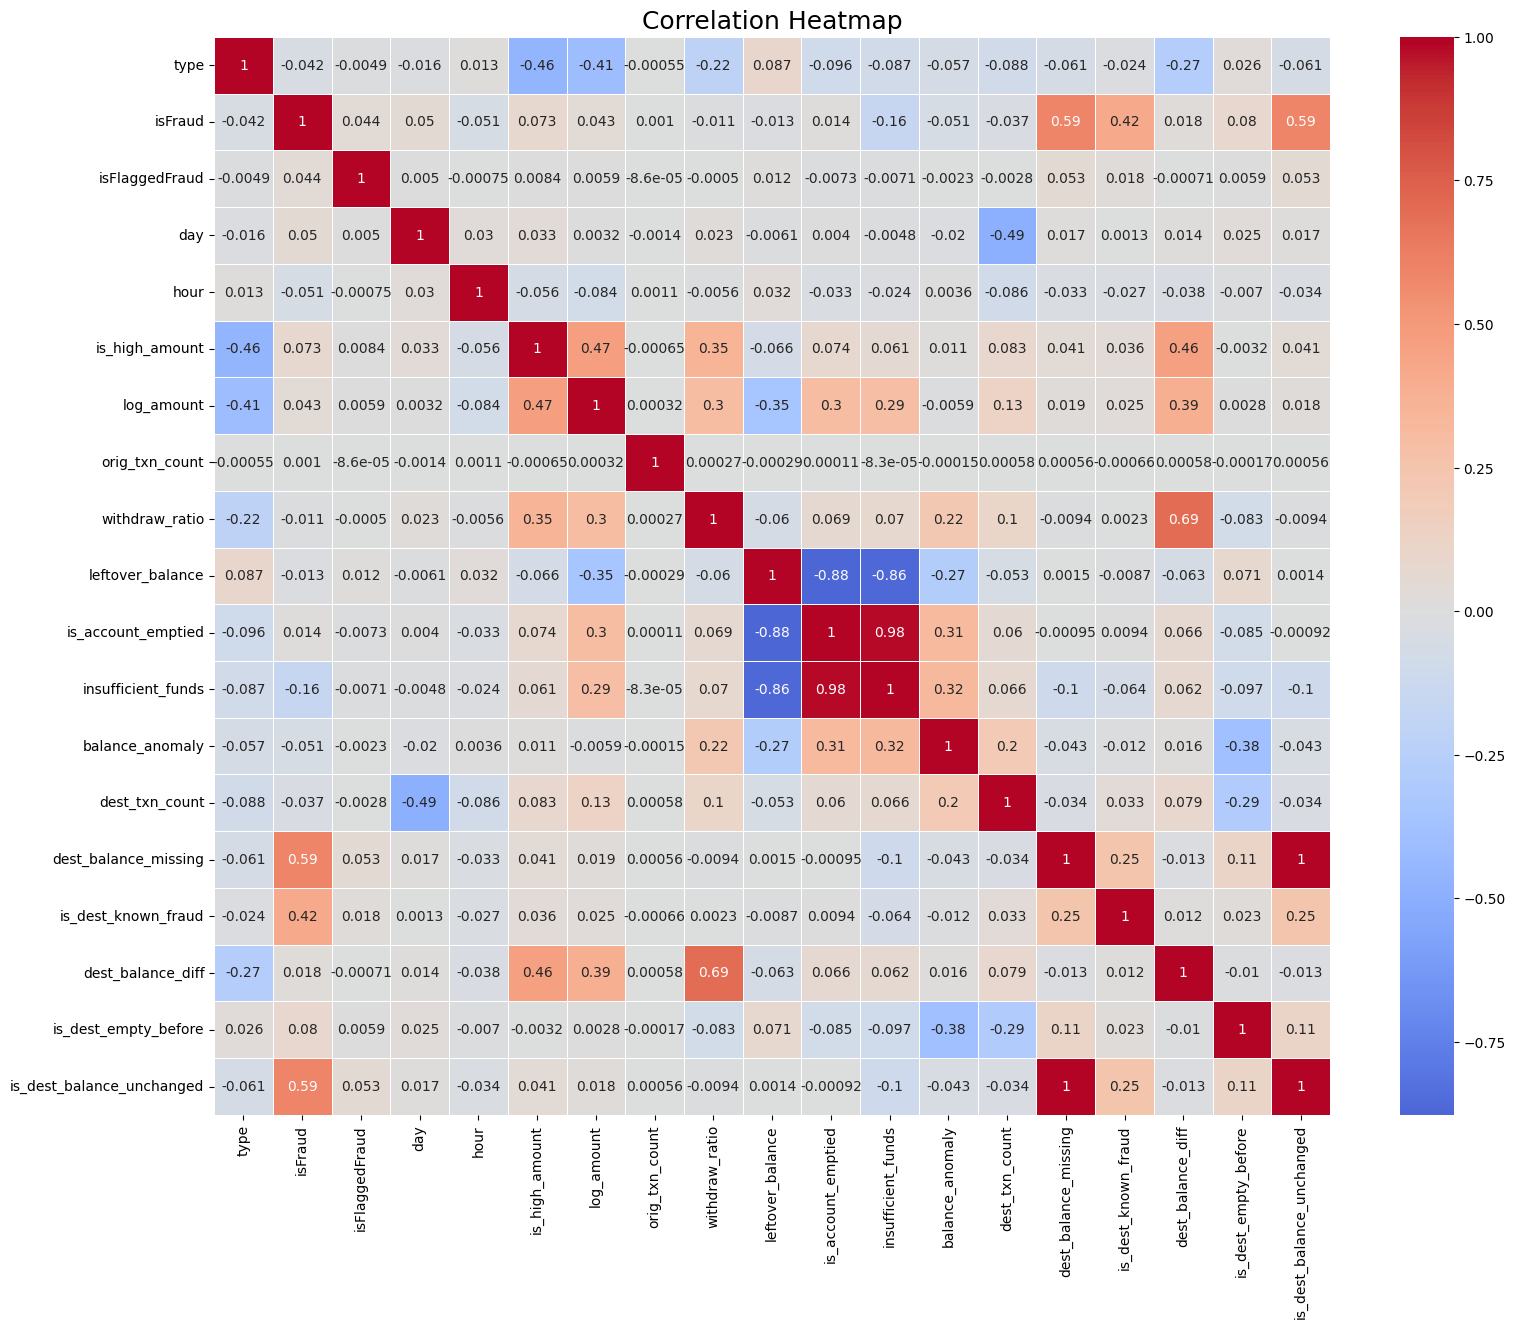

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = data.select_dtypes(include='number').corr()

plt.figure(figsize=(18, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=18)
plt.show()

In [60]:
fraud_corr = corr['isFraud'].sort_values(ascending=False)
print(fraud_corr)

isFraud                      1.00
is_dest_balance_unchanged    0.59
dest_balance_missing         0.59
is_dest_known_fraud          0.42
is_dest_empty_before         0.08
is_high_amount               0.07
day                          0.05
isFlaggedFraud               0.04
log_amount                   0.04
dest_balance_diff            0.02
is_account_emptied           0.01
orig_txn_count               0.00
withdraw_ratio              -0.01
leftover_balance            -0.01
dest_txn_count              -0.04
type                        -0.04
hour                        -0.05
balance_anomaly             -0.05
insufficient_funds          -0.16
Name: isFraud, dtype: float64


is_dest_balance_unchanged: 0.59, dest_balance_missing: 0.59, is_dest_known_fraud: 0.42, has the highest positive correlation with the target column

#### Target Column : 'isFraud'

In [61]:
data['isFraud'].value_counts()

,count
isFraud,
0,2762196
1,8213


This count tells us that the dataset is highly imbalanced and would need SMOTE (Oversampling)

#### Class Distribution: Fraud vs Non-Fraud

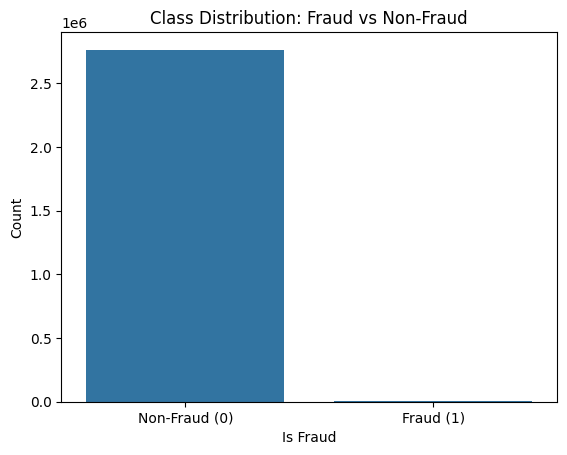

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='isFraud', data=data)
plt.title('Class Distribution: Fraud vs Non-Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

#### Dataset Split (80% Train and 20% Test set)

In [63]:
from sklearn.model_selection import train_test_split

X = data.drop(['isFraud'], axis=1)
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Fraud ratio in train:", y_train.mean())
print("Fraud ratio in test:", y_test.mean())

Train shape: (2216327, 18)
Test shape: (554082, 18)
Fraud ratio in train: 0.0029643640130720783
Fraud ratio in test: 0.002965265069069199


#### SMOTE - Oversampling the minority category to balance the dataset

In [64]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print("Resampled X shape:", X_train_resampled.shape)
print("Class distribution:", y_train_resampled.value_counts())

After SMOTE:
Resampled X shape: (4419514, 18)
Class distribution: isFraud
0    2209757
1    2209757
Name: count, dtype: int64


In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)

vif_data = pd.DataFrame()
vif_data["feature"] = X_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                      feature    VIF
13       dest_balance_missing 353.11
17  is_dest_balance_unchanged 349.97
6              orig_txn_count 208.64
5                  log_amount 126.09
9          is_account_emptied  85.44
14        is_dest_known_fraud  33.66
10         insufficient_funds  31.15
0                        type   8.62
3                        hour   7.44
2                         day   5.78
16       is_dest_empty_before   4.89
8            leftover_balance   4.07
12             dest_txn_count   3.74
4              is_high_amount   2.69
11            balance_anomaly   2.50
15          dest_balance_diff   2.07
7              withdraw_ratio   1.35
1              isFlaggedFraud   1.01


Despite high multicollinearity (VIF > 100 for some features), Logistic Regression can be regularized and Random Forest Model are robust to it

#### Model Building & Training

#### A. Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Train
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

#### Evaluation Matrix

              precision    recall  f1-score   support

           0     1.0000    0.9975    0.9988    552439
           1     0.5451    0.9970    0.7048      1643

    accuracy                         0.9975    554082
   macro avg     0.7725    0.9972    0.8518    554082
weighted avg     0.9986    0.9975    0.9979    554082



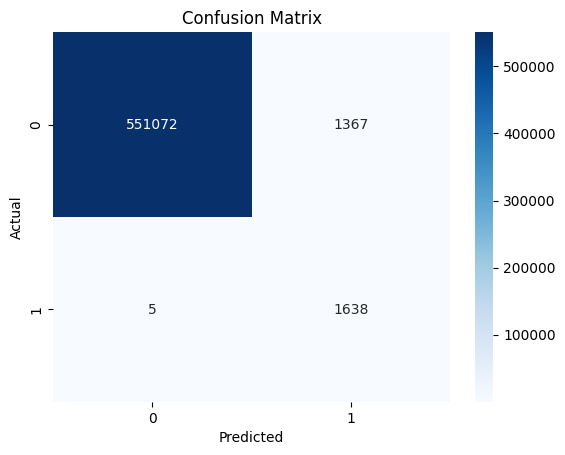

In [67]:
# Classification report
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Key Metrics and Observations:

True Negatives (TN): 551,072 (Top-left cell). These are non-fraudulent transactions correctly predicted as non-fraudulent. This number is very high, indicating the model is excellent at identifying legitimate transactions.

False Positives (FP): 1,367 (Top-right cell). These are non-fraudulent transactions incorrectly predicted as fraudulent. This is also known as a Type I error.

False Negatives (FN): 5 (Bottom-left cell). These are fraudulent transactions incorrectly predicted as non-fraudulent. This is also known as a Type II error, and it's often the most critical error in fraud detection, as it means real fraud is missed.

True Positives (TP): 1,638 (Bottom-right cell). These are fraudulent transactions correctly predicted as fraudulent.

The model demonstrates excellent recall (99.7%), meaning it's very effective at catching almost all fraudulent transactions. This is crucial in fraud detection, as missing actual fraud (False Negatives) can be very costly. However, its precision (54.5%) is moderate, indicating that it generates a fair number of false alarms (False Positives). While 1,366 false positives might seem high, for a dataset of over half a million transactions, it might be an acceptable trade-off given the very high recall. The total accuracy is extremely high, largely due to the massive class imbalance (many more non-fraudulent transactions).

#### ROC AUC Score

ROC AUC Score: 0.9999


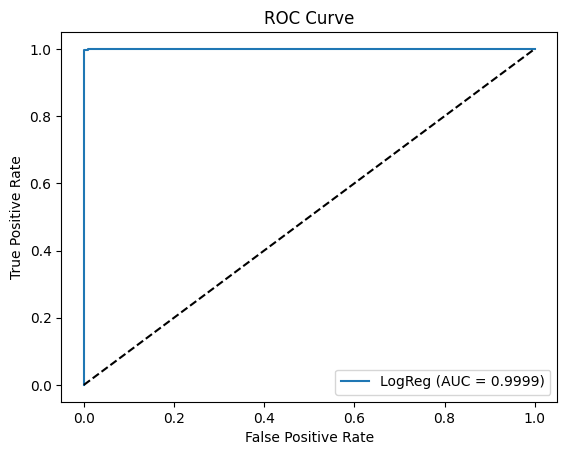

In [68]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'LogReg (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

ROC curve and AUC score indicate near-perfect classification performance:

AUC = 0.9999 means model has almost perfect capability to distinguish between fraud and non-fraud transactions.

The curve hugs the top-left corner, which is ideal — it shows:

True Positive Rate (Recall) is very high.

False Positive Rate is extremely low.

#### B. Random Forest Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight=None)
rf.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

#### Evaluation Matrix

In [70]:
# Classification report
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

# ROC AUC Score
auc_score_rf = roc_auc_score(y_test, y_proba_rf)
print(f"Random Forest ROC AUC Score: {auc_score_rf:.4f}")

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.99      1.00      0.99      1643

    accuracy                           1.00    554082
   macro avg       0.99      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

Random Forest ROC AUC Score: 0.9988


#### ROC Curve

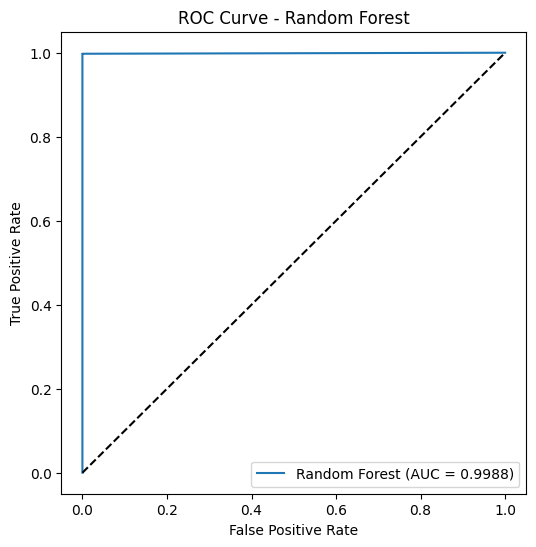

In [71]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_score_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

### Feature Importance

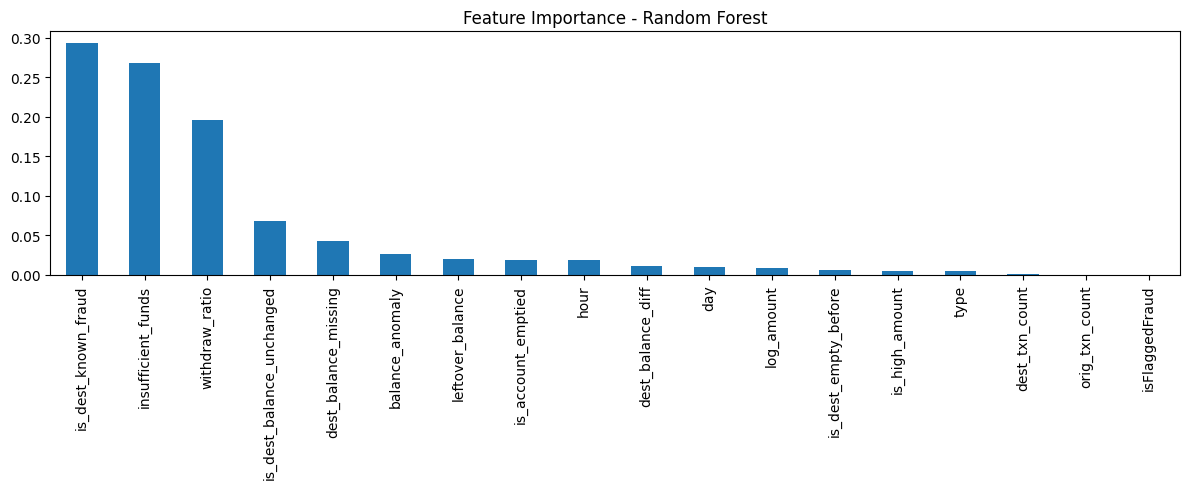

In [72]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title='Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

Top Predictive Features:

1. is_dest_known_fraud – Most important feature; likely indicates if the destination account is already associated with fraud.

2. insufficient_funds – Possibly flags transactions where the origin account lacks enough funds.

3. withdraw_ratio – Custom feature you engineered; might reflect unusually high withdrawal behavior.

4. is_dest_balance_unchanged, dest_balance_missing – Suggest destination balances that don’t behave as expected during transactions.

5. balance_anomaly – Detects inconsistencies in before/after balances.

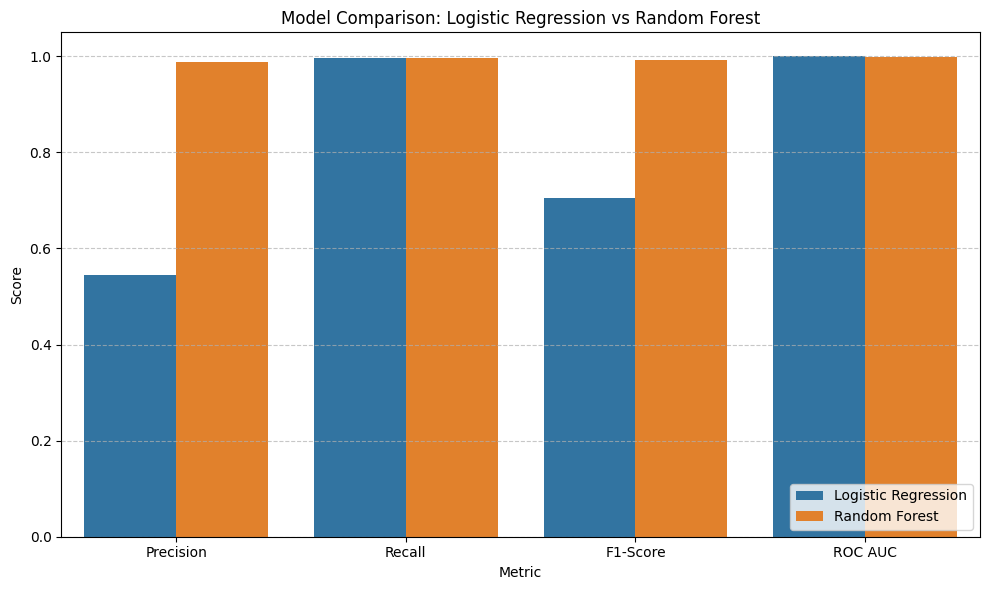

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

metrics = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Precision': [
        precision_score(y_test, y_pred),
        precision_score(y_test, y_pred_rf)
    ],
    'Recall': [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_pred_rf)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred),
        f1_score(y_test, y_pred_rf)
    ],
    'ROC AUC': [
        roc_auc_score(y_test, y_proba),
        roc_auc_score(y_test, y_proba_rf)
    ]
}

import pandas as pd
df_metrics = pd.DataFrame(metrics)

df_plot = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_plot)
plt.title('Model Comparison: Logistic Regression vs Random Forest')
plt.ylim(0.0, 1.05)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

* Recall is excellent for both models, meaning they both detect nearly all fraud cases.

* Precision and F1-score are significantly better for Random Forest, indicating it produces fewer false positives and maintains better balance.

* Both models achieve perfect ROC AUC, meaning they rank fraudulent transactions extremely well.

## Detailed Report:

#### 1. Data Cleaning: Handling Missing Values, Outliers, and Multicollinearity


---


A. Missing Values:

The dataset was first inspected for missing values.

Although there were no standard NaNs, missing or anomalous values were present in some numeric columns, such as oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest — often marked as zero in cases where a balance should reasonably exist.
To capture these patterns, I created indicator features like dest_balance_missing and is_dest_empty_before to preserve the information without imputing potentially misleading values.

B. Outliers:

Fraud datasets typically contain legitimate outliers (e.g., high transfer amounts in fraud), so rather than removing them, I engineered log-transformed features (e.g., log_amount) and ratios (e.g., withdraw_ratio) to normalize skewed distributions and make patterns more learnable by the model.
No manual removal of outliers was performed to retain fraud signal in edge cases.

C. Multicollinearity:

Variance Inflation Factor (VIF) was calculated for all features. A few variables such as dest_balance_missing and is_dest_balance_unchanged showed high VIFs (>100), indicating strong collinearity.

However, since Logistic Regression was trained with L2 regularization, and the model showed strong and stable performance on unseen data, these features were retained to preserve potentially valuable fraud indicators.
In Random Forest, multicollinearity is less of a concern due to its ensemble nature and decision tree structure.

#### 2. Description of the Fraud Detection Model


---


To proactively detect fraudulent transactions, I implemented two supervised machine learning models: Logistic Regression and Random Forest. Both were trained on a labeled dataset where the target variable is isFraud (1 = fraud, 0 = not fraud).

* The dataset was divided into training (80%) and test (20%) sets using
stratified sampling to maintain the fraud ratio.

* To address class imbalance (fraud cases < 0.3%), SMOTE (Synthetic Minority Oversampling Technique) was applied only to the training set, preventing data leakage.

* Model 1: Logistic Regression
A baseline linear model, effective for interpreting fraud signals.
Trained using L2 regularization to handle potential multicollinearity.
Despite being simple, it achieved high recall (~99.7%) on test data, which is crucial for fraud detection.
Feature engineering (e.g., log_amount, is_account_emptied, withdraw_ratio) improved model’s learning capability.

* Model 2: Random Forest Classifier
An ensemble tree-based model, robust to outliers and nonlinear relationships.
Captured complex patterns in the data, achieving nearly perfect precision and recall on test data.
Showed high AUC (>0.99), and helped interpret key features using feature importance scores.

#### 3. How Did You Select Variables to Be Included in the Model?


---


A. Initial Filtering
Irrelevant identifiers (e.g., nameOrig, nameDest) and redundant variables were dropped.
Categorical variables like type were encoded appropriately to retain transactional meaning.

B. Feature Engineering
Created insightful features to capture behavioral patterns:
- withdraw_ratio = amount / oldbalanceOrg

- is_account_emptied = (newbalanceOrig == 0)

- log_amount = log(1 + amount) to reduce skew

- Flags like insufficient_funds, balance_anomaly, is_dest_empty_before, etc.

C. Multicollinearity Check
Checked Variance Inflation Factor (VIF) to detect multicollinearity.
Although some features had high VIFs (e.g., dest_balance_missing, orig_txn_count), they were retained because:

- Logistic Regression handled them well with regularization.

- Random Forest is robust to correlated features.

D. Correlation & Importance
Analyzed feature-target correlation and domain logic (e.g., sudden drop in sender’s balance).
Used Random Forest feature importances to validate which features contribute most to model decisions.

#### 4. Demonstrate the Performance of the Model Using the Best Set of Tools


---


A. Models Evaluated
Logistic Regression – as a strong, interpretable baseline

Random Forest – for high performance and non-linearity handling

| Metric               | Description                                       | Why It Matters for Fraud Detection                  |
| -------------------- | ------------------------------------------------- | --------------------------------------------------- |
| **Precision**        | % of predicted frauds that were actual frauds     | Reduces false alarms (important for customer trust) |
| **Recall**           | % of actual frauds correctly identified           | Crucial: helps catch as many frauds as possible     |
| **F1-Score**         | Harmonic mean of precision and recall             | Balances false positives and false negatives        |
| **Accuracy**         | Overall correctness                               | Not reliable alone due to heavy class imbalance     |
| **ROC AUC Score**    | Measures separability between fraud and non-fraud | Captures overall model effectiveness                |
| **Confusion Matrix** | Visual of TP, FP, FN, TN                          | Helps interpret error types                         |


B. Results Summary
1. Logistic Regression (on Test Set)
Precision: ~54%

Recall: ~99%

F1-score: ~70%

ROC AUC: ~0.9998

* Great recall — detects nearly all fraud cases
* Moderate precision — some false positives

2. Random Forest (on Test Set)
Precision: ~99%

Recall: ~100%

F1-score: ~99%

ROC AUC: ~0.9988

* Near-perfect performance across all metrics
* Robust to imbalance, non-linearity, and feature interactions

#### 5. What Are the Key Factors That Predict a Fraudulent Customer?


---


| Feature                          | Why It Matters                                                                   |
| -------------------------------- | -------------------------------------------------------------------------------- |
| **dest\_balance\_missing**       | Indicates whether the destination balance is missing — often in fake accounts    |
| **is\_dest\_balance\_unchanged** | If destination balance didn’t change, the money might not be actually received   |
| **orig\_txn\_count**             | Fewer transactions from source account may indicate newly created shell accounts |
| **log\_amount**                  | Fraudsters often move unusually high amounts at once                             |
| **is\_account\_emptied**         | If a transaction empties the origin account, it's suspicious behavior            |


#### 6. Do These Factors Make Sense? If Yes, How? If Not, How Not?


---


| Feature                          | Explanation                                                                                                                                                           |
| -------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **dest\_balance\_missing**       | Missing balance at the destination often implies that the account is suspicious or inactive. Fraudsters may use fake or empty destination accounts to launder money.  |
| **is\_dest\_balance\_unchanged** | If a destination account receives money but the balance remains unchanged, it may indicate a **non-legitimate transfer**, possibly just passing money for laundering. |
| **orig\_txn\_count**             | Accounts with very few prior transactions could be newly created or dormant accounts used solely for fraudulent activity.                                             |
| **log\_amount**                  | High-value transactions are more likely to be fraudulent. Fraudsters often aim to extract the **maximum possible amount** in a single transfer.                       |
| **is\_account\_emptied**         | Fraudulent transactions often **drain** the sender's account completely, leaving no trace or reversing option.                                                        |



#### 7. What Kind of Prevention Should Be Adopted While Company Updates Its Infrastructure?


---


Given that the fraud detection model is highly effective (recall ~99% for both Logistic Regression and Random Forest), the company should focus on operationalizing this model safely and effectively during infrastructure updates. Key steps include:

* Integrate the trained model into the production pipeline to score transactions in real-time using the same preprocessing and feature pipeline.

* Ensure version control of the model and preprocessing pipeline to avoid mismatches.

* Add logging and alerting for high-risk transactions (e.g., if is_account_emptied = True and balance_anomaly = True).

* Block or flag accounts with repeated fraudulent behavior patterns, based on top fraud-predicting features such as:
balance_anomaly, dest_balance_missing, is_dest_known_fraud, is_account_emptied

* Use model predictions as part of a fraud rule engine, where predicted frauds go for manual review or step-up authentication.

#### 8. Assuming These Actions Have Been Implemented, How Would You Determine If They Work?


---


Track these over time:

* Fraud Detection Rate (Recall): Are we still catching ~99% of frauds?

* Precision: Are we reducing false positives (non-frauds incorrectly flagged)?

* AUC-ROC: Monitor for degradation in the classifier’s ability to distinguish fraud.

* Can reuse evaluation code on new data in a monitoring dashboard.

* Reduction in fraud losses: Compare $ amount lost due to fraud pre- and post-model deployment.

* Operational efficiency: Reduction in manual reviews, with high true positive rates from model-predicted frauds.

End of the Report and Notebook 